In [1]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [22]:
conversationPath = './Chat (1).txt' 

## Preprocessing

In [23]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateTime(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), (([0-9][0-9])|[0-9]):([0-9][0-9]) ([a][m]|[p][m]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):
    splitLine = line.split(' - ') 
    dateTime = splitLine[0] 
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:]) 
    if startsWithAuthor(message): 
        splitMessage = message.split(': ')
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)    
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None 
    
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateTime(line): #this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer

            
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head()

,Date,Time,Author,Message
0,17/07/19,12:42 am,None,"Nachiket Agni created group ""Dhwani Informal K..."
1,17/07/19,12:42 am,None,Nachiket Agni added you
2,17/07/19,12:42 am,None,"Nachiket Agni added +91 73084 92757, +91 77620..."
3,17/07/19,12:54 am,None,"Toshi Priya changed the subject from ""Dhwani I..."
4,17/07/19,1:00 am,None,"Ayush Khedia changed the subject from ""Dhwani ..."


In [24]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
0,17/07/19,12:42 am,None,"Nachiket Agni created group ""Dhwani Informal K..."
1,17/07/19,12:42 am,None,Nachiket Agni added you
2,17/07/19,12:42 am,None,"Nachiket Agni added +91 73084 92757, +91 77620..."
3,17/07/19,12:54 am,None,"Toshi Priya changed the subject from ""Dhwani I..."
4,17/07/19,1:00 am,None,"Ayush Khedia changed the subject from ""Dhwani ..."


In [25]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()
media_messages_df = df[df['Message'] == '<Media omitted>']

In [26]:
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Message
9,17/07/19,7:55 am,Sudakshina Bhattacharjee,Oh damn. 🌚
10,17/07/19,8:51 am,Ruchira Mishra,🌚
11,19/07/19,1:27 pm,Toshi Priya,I am adding our Faculty Advisors to Dhwani K16...
13,21/07/19,12:18 am,Akshat Kashyap,Pata hai
14,21/07/19,12:18 am,Toshi Priya,Han theek se rakho wahi


In [27]:
def HourSplitTo24(x):
    ap=x.split(" ")
    hour=int(ap[0].split(":")[0]) 
    alpha=ap[1]
    if alpha=="am" and hour==12:
        return "24"
    if alpha=="pm" and hour==12:
        return "12"
    if alpha=="am":
        return(str(hour))
    if alpha=="pm":
        return (str(hour+12))
    
    
messages_df['Hour'] = messages_df['Time'].apply(lambda x : HourSplitTo24(x))

In [28]:
import calendar
def DayOTW(s):
  dtlst=s.split('/')
  
  my_date=datetime.date(int(dtlst[2]),int(dtlst[1]),int(dtlst[0])) #format is year month day
  #return(calendar.day_name[my_date.weekday()])
  return (calendar.day_name[my_date.weekday()])

messages_df['Day'] = messages_df['Date'].apply(lambda s : DayOTW(s))
messages_df.head()

,Date,Time,Author,Message,Hour,Day
9,17/07/19,7:55 am,Sudakshina Bhattacharjee,Oh damn. 🌚,7,Wednesday
10,17/07/19,8:51 am,Ruchira Mishra,🌚,8,Wednesday
11,19/07/19,1:27 pm,Toshi Priya,I am adding our Faculty Advisors to Dhwani K16...,13,Friday
13,21/07/19,12:18 am,Akshat Kashyap,Pata hai,24,Sunday
14,21/07/19,12:18 am,Toshi Priya,Han theek se rakho wahi,24,Sunday


In [29]:
WordList=[]
patternq='\?+|\s+'
for i in messages_df.Message:
  row=re.split(r';|,|:|\/|\*|\n|-|\.|\s',i)
  for j in row:
    x=re.sub(patternq,'',j)
    j=x
  WordList.append(row)

messages_df.insert(4,"Words",WordList)
#df.drop('Words', axis=1, inplace=True)
messages_df.head(5)
messages_df.reset_index(drop=True, inplace=True)

In [30]:
messages_df.head()

,Date,Time,Author,Message,Words,Hour,Day
0,17/07/19,7:55 am,Sudakshina Bhattacharjee,Oh damn. 🌚,"[Oh, damn, , 🌚]",7,Wednesday
1,17/07/19,8:51 am,Ruchira Mishra,🌚,[🌚],8,Wednesday
2,19/07/19,1:27 pm,Toshi Priya,I am adding our Faculty Advisors to Dhwani K16...,"[I, am, adding, our, Faculty, Advisors, to, Dh...",13,Friday
3,21/07/19,12:18 am,Akshat Kashyap,Pata hai,"[Pata, hai]",24,Sunday
4,21/07/19,12:18 am,Toshi Priya,Han theek se rakho wahi,"[Han, theek, se, rakho, wahi]",24,Sunday


## WordCloud

In [31]:
Mobj=messages_df.Message.str.split(expand=True).stack().value_counts()

In [32]:
wordsdf = pd.DataFrame(Mobj)
wordsdf=wordsdf.reset_index()
wordsdf.columns=['Word','Frequency']

words = ' '.join(wordsdf['Word'])

In [33]:
wordsdf.head()

,Word,Frequency
0,Happy,2066
1,birthday,993
2,Birthday,763
3,hai,524
4,the,405


In [34]:
wordlist=[]
for i in wordsdf['Word']:
   wordlist.append(i.lower())

wordz=" ".join(wordlist)

In [35]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib 

In [48]:
wc_mask = np.array(Image.open("./blackguitar1.png"))

In [49]:
OrangeBlue3=["#FA6A21", "#FA6A21", "#F58311", "#00A6E0", "#4E8AD9", "#3b5e91"] 
colorstomap=OrangeBlue3
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("mycmap", colorstomap)

In [50]:
stopwords1=[]
#words = ' '.join(df_Mobj['Word'])
#print(words)
newwordstostop=["??",'attached)','(file','omitted>','<Media','?',"JPG","jpg","IMG","HTTPS","VID","mp4","com","youtu","webp","maps","google"]
newerwords=["opus","ptt","PDF","be","STK","thi","www","i","I"]
wastop=[]
#WA0000 type stop
alist=["%.4d" % i for i in range(0,500)]
for i in alist:
  stop="WA"+str(i)
  wastop.append(stop)
  #print(stop, end=' ')

for i in newwordstostop:
  stopwords1.append(i)
for i in wastop:
  stopwords1.append(i)
for i in newerwords:
  stopwords1.append(i)

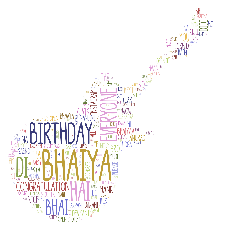

In [53]:
#background_color="black"
#background_color="rgba(255, 255, 255, 0)", mode="RGBA", 
ToSavePlot=True
wordcloud = WordCloud(font_path='./DJB The Generic.ttf',
                      stopwords=stopwords1,
                      background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                      width=2000,
                      height=1400,
                      colormap='tab20b',
                      mask=wc_mask
                     ).generate(words)
if  ToSavePlot:
    wordcloud.to_file('./plots/mywc.png')
plt.imshow(wordcloud)
plt.axis('off')
plt.show() 